# Imports

In [2]:
from pprint import pprint 
from pathlib import Path
import dataclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import altair as alt
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import safetensors

import IPython.display as ipy_display
sns.set_style('darkgrid')

from safetensors.torch import safe_open
from sklearn.preprocessing import StandardScaler

from __future__ import annotations

from typing import Sequence
from torch import Tensor
from jaxtyping import Float, Integer
from enum import StrEnum, auto

# Functions

In [4]:
StringArray = Sequence[str]
Array = Tensor | np.ndarray
ArrayInt = Integer[Array, 'n']
DiscreteArray = ArrayInt | StringArray

@dataclasses.dataclass
class SplitTuple:
    train : Sequence[int]
    val: Sequence[int]
    test: Sequence[int]
    
    def __post_init__(self):
        """Raises error if split parts overlap."""
        for a, b in [('train', 'val'), ('val', 'test'), ('test', 'train')]:
            overlap = np.intersect1d(getattr(self, a), getattr(self, b))
            if overlap.shape[0]:
                raise ValueError(
                    f'Found {len(overlap)} overlapping items between {a} and {b}.'
                )
    
    def __len__(self) -> int:
        return len(self.train) + len(self.val) + len(self.test)

    def trainval(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val], axis=0)

    def indices(self) -> DiscreteArray:
        return np.concatenate([self.train, self.val, self.test], axis=0)

    def as_dict(self) -> dict[str, DiscreteArray]:
        return dataclasses.asdict(self)
    
    @classmethod
    def from_lists(
        cls,
        train: DiscreteArray,
        val: DiscreteArray,
        test: DiscreteArray
    ) -> 'SplitTuple':
        return cls(
            train=np.asarray(train),
            val=np.asarray(val),
            test=np.asarray(test)
        )
        
def load_embeddings(file):
    tensors = {}
    with safetensors.safe_open(str(file), framework='pt') as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k).numpy()
    return tensors
    
class ArrayMap:
    """Map discrete values (sequences, int, smiles) to arrays."""

    def __init__(self, keys, values):

        self.mapper = pd.Series(data=np.arange(len(keys)), index=keys)
        self.values = values
        # Check for duplicates.
        dups = self.mapper.index[self.mapper.index.duplicated()].tolist()
        if dups:
            raise ValueError(f'Found {len(dups)} duplicated isosmiles={dups}')
    
    @classmethod
    def from_dict(cls, adict) -> ArrayMap:
        return ArrayMap(np.array(list(adict.keys())), np.stack(list(adict.values())))

    @classmethod
    def load(cls, fname: str) -> ArrayMap:
        data = load_embeddings(fname)
        return cls.from_dict(data)

    @property
    def keys(self):
        return list(self.mapper.index)
        

    def __call__(self, key_array: types.DiscreteArray):
        assert isinstance(key_array, np.ndarray), 'expected np.ndarray as input!'
        return self.values[self.mapper[key_array].values]
        
def html_header(text:str, n:int = 2)-> None:
    ipy_display.display(ipy_display.HTML(f'<h{n}>{text}</h{n}>'))

    
def peek_df(df:pd.DataFrame, title:str=None, n=5)-> None:
    if title:
        if is_notebook():
            html_header(f'{title:-^30}')
        else:
            print(f'{title:-^30}')
        
    print(f'Columns: {df.columns}')
    print(f'Shape: {df.shape}')
    if n > 0 and is_notebook():
        ipy_display.display(df.head(n=n))

def estimate_clusters_silhouette(embeddings, max_k=10):
    embeddings_norm = sklearn.preprocessing.normalize(embeddings, norm='l2', axis=1)
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings_norm)
        score = sklearn.metrics.silhouette_score(embeddings, cluster_labels, metric='cosine')
        silhouette_scores.append(score)

    best_k = k_range[np.argmax(silhouette_scores)]
    return best_k
    
def plot_pairwise_distances(embeddings, labels, cmap, name):
    dist_matrix = sklearn.metrics.pairwise_distances(embeddings, metric='cosine')
    n_clusters = estimate_clusters_silhouette(embeddings)
    sc = sklearn.cluster.SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', random_state=42)
    cluster_labels = sc.fit_predict(embeddings)
    sorted_indices = np.argsort(cluster_labels)
    plot_matrix = dist_matrix[sorted_indices, :][:, sorted_indices]
    labels = np.array(labels)[sorted_indices]

    
    fig = plt.figure(figsize=(12, 14)) # Adjusted figsize for hist+heatmap
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], hspace=0.05)
    ax_hist = fig.add_subplot(gs[0, 0])
    ax_heatmap = fig.add_subplot(gs[1, 0])

    upper_triangle_indices = np.triu_indices_from(dist_matrix, k=1)
    distances = dist_matrix[upper_triangle_indices]

    ax_hist.hist(distances, bins=50, color='grey', alpha=0.7, density=True)
    sns.kdeplot(distances, color='black', ax=ax_hist, warn_singular=False)
    ax_hist.set_title(f'Pairwise Cosine Distances {name}')
    ax_hist.set_xlim(0.0, max(1.0, np.max(distances) * 1.05) if distances.size > 0 else 1.0)
    ax_hist.set_ylabel('Density')
    ax_hist.xaxis.tick_top()
    ax_hist.xaxis.set_label_position('top')

    heatmap_plot = sns.heatmap(
        plot_matrix,
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Cosine Distance', 'shrink': 0.8},
        cbar_ax=fig.add_axes([0.92, 0.15, 0.02, 0.6]),
        vmin=0.0,
        vmax=max(1.0, np.max(plot_matrix) if plot_matrix.size > 0 else 1.0),
        xticklabels=labels,
        yticklabels=labels,
        ax=ax_heatmap
    )
    ax_heatmap.tick_params(axis='x', rotation=90)
    ax_heatmap.tick_params(axis='y', rotation=0)
    if len(labels) > 50:
         heatmap_plot.set_xticklabels(heatmap_plot.get_xticklabels(), size=6)
         heatmap_plot.set_yticklabels(heatmap_plot.get_yticklabels(), size=6)

    gs.tight_layout(fig, rect=[0, 0, 0.9, 1])

# Paths and Constants

In [5]:
class PathsAndConstants:
    data_path = Path('../data/processed')
    raw_path = Path('../data/raw')
    results_path = Path('../results')
    label_csv = data_path / 'protein_substrate.csv'
    protein = 'protein_name'
    protein_embs = {'ESM2_T6': data_path / 'protein_esm2t6.safetensors', 'ESM2_T33': data_path / 'protein_esm2t33.safetensors'}
    mol = 'substrate_name'
    mol_embs = {'RDKit2D': data_path / 'substrate_rdkit2d.safetensors'}
    raw_label = 'value'
    measurement = 'Specific Activity'
    label = f'log10({measurement})'
    unit='μmol.min⁻¹.mg⁻¹'

_C = PathsAndConstants()
_C

# Results

## Clasification models

In [12]:
class_results_df = pd.read_csv(_C.results_path/'pred_results' / 'class_results.csv')
class_preds_df = pd.read_csv(_C.results_path/'pred_results' / 'preds_class_data.csv')

In [13]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
group_cols = ['model', 'protein_embeddings', 'substrate_embeddings']
agg_df = (
    class_results_df
      .groupby(group_cols)[metrics]
      .agg(['mean', 'std'])
)
agg_df.columns = [
    f'{stat.title()} {metric}'
    for metric, stat in agg_df.columns
]

summary_df = agg_df.reset_index()
summary_df

,model,protein_embeddings,substrate_embeddings,Mean accuracy,Std accuracy,Mean precision,Std precision,Mean recall,Std recall,Mean f1_score,Std f1_score,Mean roc_auc,Std roc_auc
0,Logistic,ESM2_T33,RDKit2D,0.859885,0.018650,0.862381,0.021062,0.989363,0.018736,0.921227,0.010979,0.887504,0.023638
1,Logistic,ESM2_T6,RDKit2D,0.861133,0.036868,0.890083,0.030817,0.950478,0.026365,0.918932,0.021813,0.883215,0.025414
2,Logistic,ESMC,RDKit2D,0.844368,0.025991,0.862126,0.025554,0.967363,0.017006,0.911455,0.015337,0.840827,0.032993
3,NGBoost,ESM2_T33,RDKit2D,0.881714,0.020123,0.899368,0.021675,0.966238,0.026791,0.931182,0.011960,0.893525,0.032226
4,NGBoost,ESM2_T6,RDKit2D,0.875403,0.022946,0.900807,0.014846,0.955390,0.027296,0.927028,0.013512,0.876256,0.030242
5,NGBoost,ESMC,RDKit2D,0.876553,0.026757,0.899802,0.021915,0.958397,0.030650,0.927763,0.016456,0.896454,0.031174
6,RF,ESM2_T33,RDKit2D,0.866179,0.035110,0.911367,0.030398,0.930157,0.039560,0.919886,0.021836,0.878307,0.031466
7,RF,ESM2_T6,RDKit2D,0.863598,0.036205,0.910686,0.025204,0.927105,0.041441,0.918158,0.023192,0.876615,0.034606
8,RF,ESMC,RDKit2D,0.862382,0.033602,0.905459,0.019532,0.931721,0.040140,0.917866,0.021374,0.874942,0.035714
9,XGBoost,ESM2_T33,RDKit2D,0.903609,0.018289,0.933921,0.024313,0.952359,0.030825,0.942430,0.011070,0.927638,0.026652


## Baseline models

In [29]:
results_df = pd.read_csv(_C.results_path/'pred_results' / 'baseline_results.csv')
splits_df = pd.read_csv(_C.results_path/'pred_results' / 'splits_baselines_data.csv')

In [30]:
# Initialize an empty list to store rows
rows = []

# Loop through models and embeddings
for model in results_df.model.unique():
    for emb in results_df.protein_embeddings.unique():
        model_df = results_df[
            (results_df.model == model) &
            (results_df.protein_embeddings == emb)
        ]
        mean_r2 = model_df['R^2'].mean()
        std_r2 = model_df['R^2'].std()
        
        # Append a row to the list
        rows.append({
            'Model': model,
            'Protein Embedding': emb,
            'Mean R²': round(mean_r2, 3),
            'Std R²': round(std_r2, 3)
        })

summary_df = pd.DataFrame(rows)
summary_df

,Model,Protein Embedding,Mean R²,Std R²
0,RF,ESM2_T6,0.665,0.117
1,RF,ESM2_T33,0.690,0.133
2,RF,ESMC,0.686,0.113
3,Linear,ESM2_T6,0.521,0.190
4,Linear,ESM2_T33,0.521,0.190
5,Linear,ESMC,0.521,0.190
6,XGBoost,ESM2_T6,0.653,0.096
7,XGBoost,ESM2_T33,0.715,0.064
8,XGBoost,ESMC,0.716,0.067
9,NGBoost,ESM2_T6,0.691,0.090


(40, 8)


/tmp/ipykernel_11339/271242471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='model', y='R^2', data=df_sub, palette='Set2')


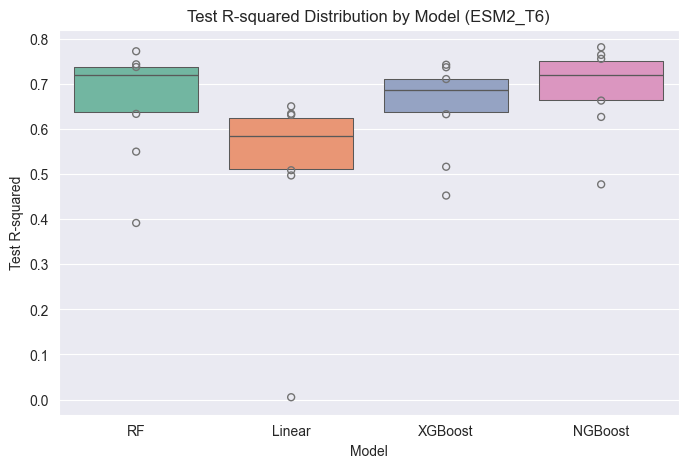

/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')
/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')


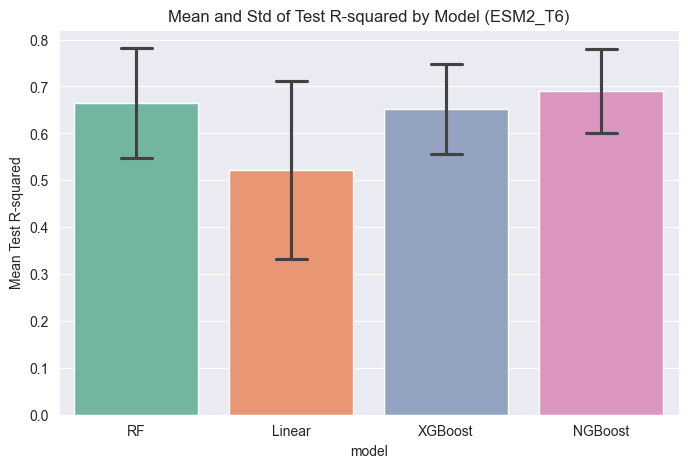

(40, 8)


/tmp/ipykernel_11339/271242471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='model', y='R^2', data=df_sub, palette='Set2')


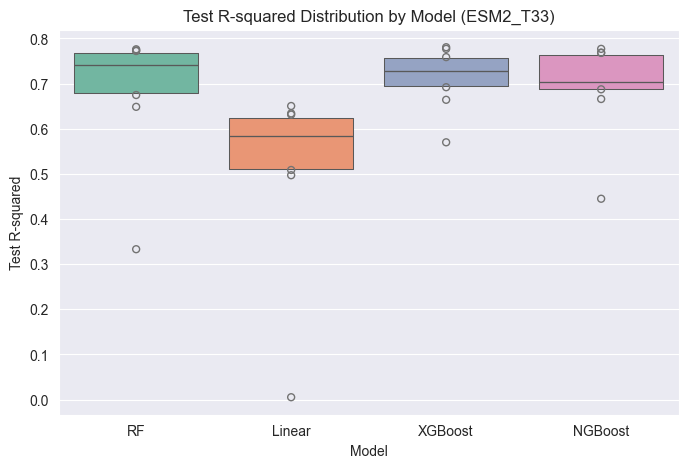

/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')
/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')


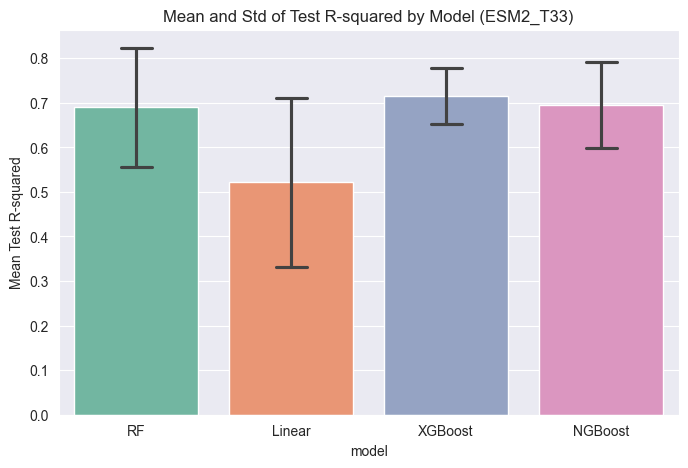

/tmp/ipykernel_11339/271242471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='model', y='R^2', data=df_sub, palette='Set2')


(40, 8)


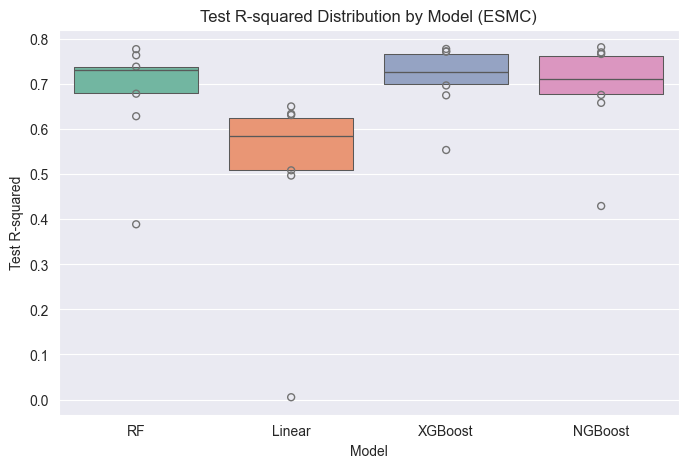

/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')
/tmp/ipykernel_11339/271242471.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')


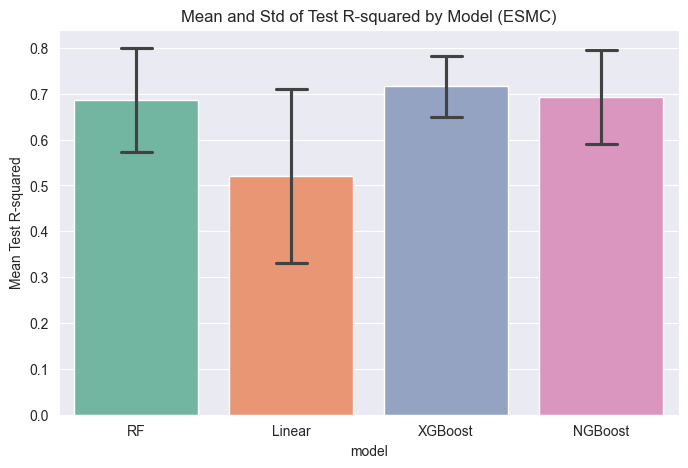

In [31]:
for emb in results_df.protein_embeddings.unique():
    df_sub = results_df[results_df.protein_embeddings == emb]
    print(df_sub.shape)
    plt.figure(figsize=(8,5))
    sns.boxenplot(x='model', y='R^2', data=df_sub, palette='Set2')
    plt.title(f"Test R-squared Distribution by Model ({emb})")
    plt.ylabel("Test R-squared")
    plt.xlabel("Model")
    plt.savefig(_C.results_path / 'pred_results' / f'{emb}_test_boxplot', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x='model', y='R^2', data=df_sub, ci='sd', capsize=0.2, palette='Set2')
    plt.ylabel("Mean Test R-squared")
    plt.title(f'Mean and Std of Test R-squared by Model ({emb})')
    plt.savefig(_C.results_path / 'pred_results' / f'{emb}_test_barplot', dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
def plot_true_vs_pred_altair(df, x_col='y_true', y_col='y_pred', id_col=_C.protein, id_col2=_C.mol, title=''):
    # Determine limits for the axes and the perfect fit line
    min_val = min(df[x_col].min(), df[y_col].min())
    max_val = max(df[x_col].max(), df[y_col].max())
    margin = (max_val - min_val) * 0.05
    lim_min = min_val - margin
    lim_max = max_val + margin

    # Create the base scatter plot
    scatter = alt.Chart(df).mark_circle(size=60, opacity=0.7).encode(
        x=alt.X(f'{x_col}:Q', scale=alt.Scale(domain=[lim_min, lim_max])),
        y=alt.Y(f'{y_col}:Q', scale=alt.Scale(domain=[lim_min, lim_max])),
        color=alt.Color(f'{id_col}:N'), # Use :N for nominal/categorical data
        tooltip=[x_col, y_col, id_col, id_col2] # Add other columns from df as needed
    ).properties(
         title=title,
         width=600,
         height=600
    )
    line_data = pd.DataFrame({'x': [lim_min, lim_max], 'y': [lim_min, lim_max]})
    line = alt.Chart(line_data).mark_line(color='red', strokeDash=[5,5]).encode(
        x='x:Q',
        y='y:Q'
    )
    chart = (scatter + line).interactive()

    return chart

## Enzymatch results

In [35]:
clip_box = pd.read_csv(_C.results_path / 'CLIP results' / 'clip_metrics_by_fold.csv')
metrics = ['mse', 'r2', 'mae', 'kendall_tau']
df_meaned = clip_box.groupby(['embedding', 'split'])[metrics].mean()
df_meaned = df_meaned.reset_index()
if 'fold' in df_meaned.columns:
    df_meaned = df_meaned.drop(columns=['fold'])

df_meaned = df_meaned.sort_values(by=['embedding', 'split'])
display(df_meaned)

,embedding,split,mse,r2,mae,kendall_tau
0,ESM2_T33,test,0.506556,0.609950,0.538138,0.591450
1,ESM2_T33,train,0.284883,0.784549,0.392973,0.719337
2,ESM2_T33,val,0.494985,0.570267,0.528707,0.572759
3,ESM2_T6,test,0.514817,0.602477,0.535610,0.591693
4,ESM2_T6,train,0.260120,0.803449,0.362779,0.743633
5,ESM2_T6,val,0.505736,0.564189,0.522353,0.580903
6,ESMC,test,0.511145,0.608368,0.529892,0.604042
7,ESMC,train,0.237898,0.819921,0.349205,0.753613
8,ESMC,val,0.504630,0.565891,0.515484,0.580345


# Merged results

/tmp/ipykernel_5079/925944840.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


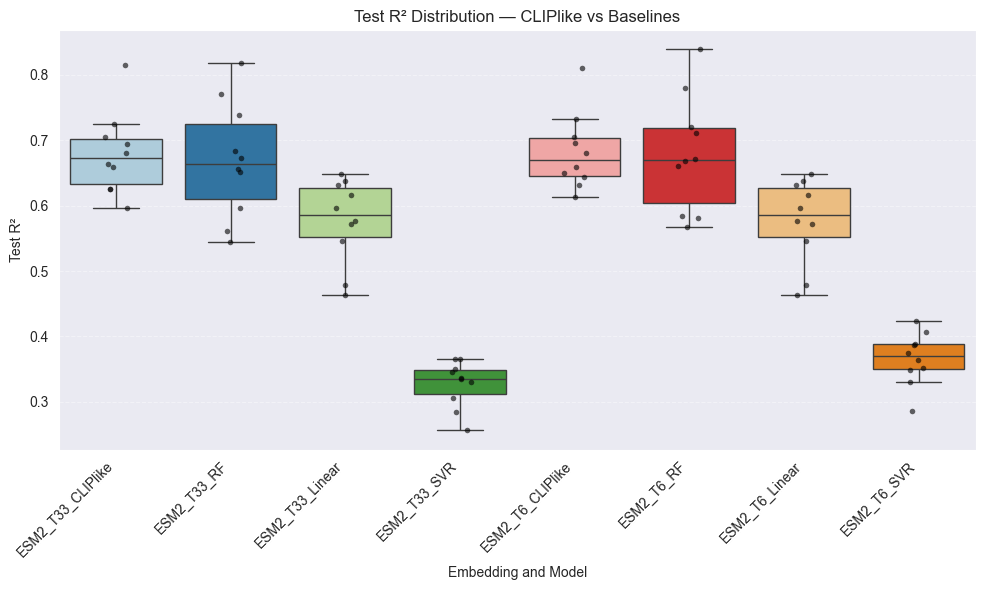

In [13]:
clip_raw = pd.read_csv(_C.results_path / 'CLIP results' / 'clip_metrics_by_fold.csv')
clip_test = (
    clip_raw[clip_raw['split']=='test']
    .rename(columns={'embedding':'protein_embeddings','r2':'R^2'})
    .assign(model='CLIP', subset='test')
    [['protein_embeddings','model','fold','R^2','subset']]
)
base_raw = pd.read_csv(_C.results_path / 'pred_results' / 'baseline_results.csv')
base_test = (
    base_raw
    .rename(columns={'split':'fold','R^2':'R^2'})
    .assign(subset='test')                         
    [['protein_embeddings','model','fold','R^2','subset']]
)


#Concat CLIP and baselines
df_all = pd.concat([clip_test, base_test], ignore_index=True)
df_all['model'] = df_all['model'].replace({'CLIP': 'CLIPlike'})
df_all['label'] = df_all['protein_embeddings'] + '_' + df_all['model']
embs   = ['ESM2_T33','ESM2_T6']
models = ['CLIPlike','RF','Linear','SVR']
order  = [f"{e}_{m}" for e in embs for m in models]

palette = sns.color_palette("Paired", n_colors=len(order))
plt.figure(figsize=(10,6))
#Box-plot
ax = sns.boxplot(
    x='label',
    y='R^2',
    data=df_all,
    order=order,
    palette=palette,
    showfliers=False
)

# Strip-plot
sns.stripplot(
    x='label',
    y='R^2',
    data=df_all,
    order=order,
    color='k',         # black color
    size=4,            # size
    jitter=True,       # dispersion so they don't overlap
    alpha=0.6,         # Trnsparency
    ax=ax
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Embedding and Model')
plt.ylabel('Test R²')
plt.title('Test R² Distribution — CLIPlike vs Baselines')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [15]:
clips = pd.read_csv(_C.results_path / 'CLIP results' / 'clip_metrics_summary_across_folds.csv')
clips

,embedding,split,mse_mean,mse_std,r2_mean,r2_std,count
0,ESM2_T33,test,0.469502,0.114545,0.678745,0.062115,10
1,ESM2_T33,train,0.249807,0.087879,0.840532,0.057336,10
2,ESM2_T33,val,0.461502,0.202731,0.700106,0.131632,10
3,ESM2_T6,test,0.464703,0.112318,0.682268,0.057799,10
4,ESM2_T6,train,0.215069,0.059970,0.863384,0.034754,10
5,ESM2_T6,val,0.460170,0.211361,0.701390,0.134895,10
